In [7]:
import hopsworks
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import torch
import seaborn as sns
import numpy as np

In [8]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/221335
Connected. Call `.close()` to terminate connection gracefully.


In [ ]:
# create feature view 
fg = fs.get_feature_group(name = 'finalproj', version=1)
query = fg.select(['statement', 'label'])

def preprocess_df(label: str) -> str:
    replacements = {
        'true': 0,
        'mostly-true': 2,
        'half-true': 2,
        'false': 1,
        'pants-fire': 1,
        'barely-true': 1,
        'full-flop': 1
    }

    return replacements.get(label, label)  

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_bert(data):
    return tokenizer.encode_plus(
        data,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=512,          # Pad & truncate all sentences.
        padding='max_length',
        truncation=True,
        return_attention_mask=True, # Return attention mask
        return_tensors='pt'     # Return PyTorch tensors
    )

'''There's something wrong with the code, getting this error:
AttributeError: module '__main__' has no attribute '__file__' 
'''
# transformation_function_create = fs.create_transformation_function(
#             transformation_function=preprocess_df,
#             output_type=str,
#             version=1
#             )

# transformation_function_create.save()

'''output type does not support pytorch tensor'''
# transformation_function_create = fs.create_transformation_function(
#             transformation_function=tokenizer_bert,
#             output_type=Tensor,
#             version=1
#             )

# transformation_function_create.save()

# fs.register_builtin_transformation_functions()

# encoding = fs.get_transformation_function(name="preprocess_df",version= 1)
# tokenizer = fs.get_transformation_function(name="tokenize_bert",version= 1)
# transformation_function = {'statement': tokenizer, 'label': encoding}

fv = fs.create_feature_view(
    name = 'base_model_features',
    query = query,
    version = 2, 
    labels =['label'],
)


In [40]:
# model_features = fs.get_feature_view(name='base_model_features', version = 1)
# model_features

In [41]:
# X_train, X_test, y_train, y_test = model_features.train_test_split(test_size = 0.2)

Finished: Reading data from Hopsworks, using Hive (1.82s) 


In [9]:
fg = fs.get_feature_group(name = 'finalproj', version=1)
query = fg.select(['statement', 'label']).read()

Finished: Reading data from Hopsworks, using ArrowFlight (1.08s) 


In [10]:
query.isnull().values.any()

False

In [11]:
# Encode labels
def encode_label(label: str):
    replacements = {
        'true': 0,
        'mostly-true': 2,
        'half-true': 2,
        'false': 1,
        'pants-fire': 1,
        'barely-true': 1,
        'full-flop': 1
    }
    return replacements.get(label, label)

query['label'] = query['label'].apply(encode_label)
query['label']

0      1
1      1
2      1
3      1
4      2
      ..
595    1
596    1
597    1
598    1
599    1
Name: label, Length: 600, dtype: int64

2024-01-04 01:29:47,959 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-01-04 01:29:47,964 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='label', ylabel='count'>

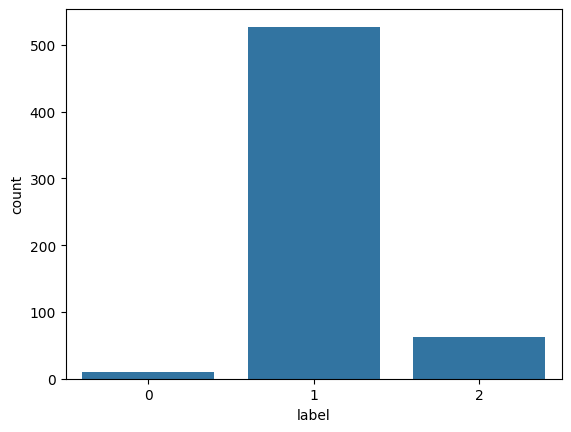

In [12]:
# Skewed distribution: need to address this
sns.countplot(x='label', data = query)

In [13]:
query['statement']

0      “Israeli Army Commander admits they handcuffed...
1      Macaulay Culkin’s “Home Alone” shopping trip t...
2      Video muestra “Palestinos cargando el cuerpo d...
3      "Los pasajeros de un avión cantan para ayudar ...
4      Gov. Tony Evers and Democrats "rejected our (I...
                             ...                        
595    “Haaretz investigation reveals discrepancies i...
596    These 13 books “have been banned from schools ...
597    Ohio’s Issue 1 “allows for abortion after viab...
598    “Navy SEALs Save Missing Maui Children” who we...
599                 U.S. Rep. Nancy Pelosi was arrested.
Name: statement, Length: 600, dtype: object

In [15]:
# Remove punctuations 
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def process_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stopwords composed of A-Z 
    and a-z only'''
    sentence = sen.lower()
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r'\b[a-zA-Z]\b', '', sentence)  # Improved single-character word removal
    sentence = re.sub(r'\s+', ' ', sentence)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    return sentence.strip()  # Strip to remove any leading or trailing whitespace

# Assuming 'query' is a DataFrame and 'statement' is a column in it
query['statement'] = query['statement'].apply(process_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jayden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
query['statement']

0      israeli army commander admits handcuffed coupl...
1      macaulay culkin home alone shopping trip cost ...
2      video muestra palestinos cargando el cuerpo de...
3      los pasajeros de un avi cantan para ayudar cal...
4      gov tony evers democrats rejected iowa model r...
                             ...                        
595    haaretz investigation reveals discrepancies is...
596                         books banned schools florida
597    ohio issue allows abortion viability financial...
598    navy seals save missing maui children padlocke...
599                            rep nancy pelosi arrested
Name: statement, Length: 600, dtype: object

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(query['statement'], query['label'], test_size=0.2)

In [29]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Tokenize all text data
def tokenize_text(text):
    return word_tokenize(text)

X_train_tokenized = X_train.apply(tokenize_text)
X_test_tokenized = X_test.apply(tokenize_text)

[nltk_data] Downloading package punkt to /Users/jayden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [55]:
all_tokens = []
for tokens_list in X_train_tokenized:  
    all_tokens.extend(tokens_list)

vocab = set(all_tokens)
vocab_size = len(vocab) + 1

print("Vocabulary Size:", vocab_size)

word_to_index = {word: i+2 for i, word in enumerate(vocab)}
word_to_index['<PAD>'] = 0  # Padding
word_to_index['<UNK>'] = 1  # Unknown words


Vocabulary Size: 2355


In [56]:
def tokens_to_indices(tokenized_text, word_to_index):
    return [word_to_index.get(word, word_to_index['<UNK>']) for word in tokenized_text]

X_train_indices = X_train_tokenized.apply(lambda x: tokens_to_indices(x, word_to_index))
X_test_indices = X_test_tokenized.apply(lambda x: tokens_to_indices(x, word_to_index))


In [59]:
X_train_indices[0]


[639, 1503, 386, 1191, 569, 1543, 1611, 1454, 1294, 1312, 2013, 834]

In [60]:
max_len = 100  # Or any other length suitable for your data

def pad_sequences(sequences, maxlen):
    return [seq[:maxlen] + [0]*(maxlen - len(seq)) if len(seq) < maxlen else seq[:maxlen] for seq in sequences]

X_train_padded = pad_sequences(X_train_indices, max_len)
X_test_padded = pad_sequences(X_test_indices, max_len)


In [63]:
len(X_train_padded[0])

100

In [136]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_padded, y_train)


2024-01-04 02:43:18,228 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-01-04 02:43:18,233 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='label', ylabel='count'>

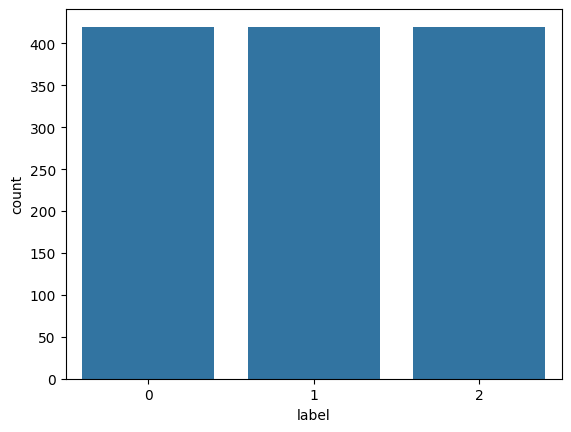

In [138]:
test = pd.DataFrame(y_train_smote)
sns.countplot(x = 'label', data = test)

In [145]:
X_train_tensor = torch.tensor(X_train_smote, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_padded, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_smote.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.long)

print("X_train_tensor shape", X_train_tensor.shape)
print("X_test_tensor shape", X_test_tensor.shape)
print("y_train_tensor shape", y_train_tensor.shape)
print("y_test_tensor shape", y_test_tensor.shape)

X_train_tensor shape torch.Size([1260, 100])
X_test_tensor shape torch.Size([120, 100])
y_train_tensor shape torch.Size([1260])
y_test_tensor shape torch.Size([120])


In [146]:
from torch.utils.data import Dataset, DataLoader
import torch

class TextDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]
# Create the dataset
train_dataset = TextDataset(X_train_tensor, y_train_tensor)
test_dataset = TextDataset(X_test_tensor, y_test_tensor)

# Create the DataLoader
batch_size = 32  
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)



In [147]:
def load_glove_embeddings(path):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
            embeddings_dict[word] = vector
    return embeddings_dict

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')

# Determine the embedding dimension from the GloVe embeddings
embedding_dim = next(iter(glove_embeddings.values())).size(0)

# Initialize an embedding matrix
vocab_size = len(vocab) + 2
embedding_matrix = torch.zeros(vocab_size, embedding_dim)

# Create a word to index mapping for vocabulary
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Populate the embedding matrix
for word, idx in word_to_idx.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        # Handle unknown words - here using random vectors
        embedding_matrix[idx] = torch.randn(embedding_dim)



In [148]:
embedding_matrix.shape

torch.Size([2356, 100])

In [151]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, num_classes, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        vocab_size, embed_dim = embedding_matrix.shape

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix)  # Initialize with GloVe
        self.embedding.weight.requires_grad = False  # Freeze embeddings

        # LSTM layer
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # Take the output of the last time step
        x = self.fc(x)
        return x

hidden_dim = 128  # Number of features in the hidden state of the LSTM
num_layers = 2    # Number of stacked LSTM layers
num_classes = 3   # Number of output classes

model = LSTMClassifier(embedding_matrix, hidden_dim, num_layers, num_classes)


In [152]:
from sklearn.metrics import f1_score
import numpy as np

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

    # Validation
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Collect all predictions and targets
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate F1 score
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    print(f'Epoch {epoch+1}, F1 Score: {f1:.2f}')

Epoch 1, Loss: 1.1021785020828248
Epoch 1, F1 Score: 0.84
Epoch 2, Loss: 1.100984016060829
Epoch 2, F1 Score: 0.84
Epoch 3, Loss: 1.0996624261140824
Epoch 3, F1 Score: 0.84
Epoch 4, Loss: 1.1000380247831345
Epoch 4, F1 Score: 0.84
Epoch 5, Loss: 1.0996547788381577
Epoch 5, F1 Score: 0.84
Epoch 6, Loss: 1.0985936403274537
Epoch 6, F1 Score: 0.00
Epoch 7, Loss: 1.0998424232006072
Epoch 7, F1 Score: 0.02
Epoch 8, Loss: 1.0991476953029633
Epoch 8, F1 Score: 0.02
Epoch 9, Loss: 1.0994437873363494
Epoch 9, F1 Score: 0.02
Epoch 10, Loss: 1.0989287823438645
Epoch 10, F1 Score: 0.00


In [154]:
help(hopsworks)

Help on package hopsworks:

NAME
    hopsworks

DESCRIPTION
    #   Copyright 2022 Logical Clocks AB
    #
    #   Licensed under the Apache License, Version 2.0 (the "License");
    #   you may not use this file except in compliance with the License.
    #   You may obtain a copy of the License at
    #
    #       http://www.apache.org/licenses/LICENSE-2.0
    #
    #   Unless required by applicable law or agreed to in writing, software
    #   distributed under the License is distributed on an "AS IS" BASIS,
    #   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    #   See the License for the specific language governing permissions and
    #   limitations under the License.
    #

PACKAGE CONTENTS
    client (package)
    command
    connection
    constants
    core (package)
    decorators
    engine (package)
    environment
    execution
    flink_cluster
    git_commit
    git_file_status
    git_op_execution
    git_provider
    git_remote
    git_re